### Set up

#### Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/Master’s Thesis/data/'

/content/drive/MyDrive/Kuliah/BDMA/Master’s Thesis/data


In [ ]:
!pip install pymeos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 92.1 MB/s eta 0:00:00


In [ ]:
!pip install --no-deps --force-reinstall --pre pymeos pymeos_cffi

  Using cached pymeos-1.1.4-py3-none-any.whl.metadata (6.6 kB)
  Using cached pymeos_cffi-1.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
Using cached pymeos-1.1.4-py3-none-any.whl (128 kB)
Using cached pymeos_cffi-1.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Attempting uninstall: pymeos_cffi
    Found existing installation: pymeos_cffi 1.1.1
    Uninstalling pymeos_cffi-1.1.1:
      Successfully uninstalled pymeos_cffi-1.1.1
  Attempting uninstall: pymeos
    Found existing installation: pymeos 1.1.4
    Uninstalling pymeos-1.1.4:
      Successfully uninstalled pymeos-1.1.4


In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 97.2 MB/s eta 0:00:00


In [ ]:
!pip install movingpandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.7 MB/s eta 0:00:00


#### Import module

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import re
from pymeos import *
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from shapely.geometry import Point, LineString
from datetime import timedelta
from pymeos import *

from pyproj import Transformer

from geopy.distance import geodesic
import movingpandas as mpd
import numpy as np
import contextily as cx

import tensorflow as tf
from sklearn.metrics.pairwise import haversine_distances

import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

/usr/local/lib/python3.10/dist-packages/movingpandas/__init__.py:37: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)


In [ ]:
pymeos_initialize()

### Data preprocessing

#### Investigating AIS data with MEOS

In [ ]:
ship_file_list = ['./ships_cleaned_3days.csv']
ship_cleaned = pd.concat(map(pd.read_csv, ship_file_list[:1]))

ship_cleaned.head()

mmsi                                             asewkt  \
0  203504300  SRID=25832;[POINT(634025.6452345413 6025063.59...   
1  203504300  SRID=25832;[POINT(634024.826457508 6025064.909...   
2  203504300  SRID=25832;[POINT(634024.8687791318 6025063.46...   
3  203504300  SRID=25832;[POINT(634028.8810075867 6025064.13...   
4  203504300  SRID=25832;[POINT(634025.4697053663 6025065.15...   

                                                 sog  \
0  [0@2023-10-01 04:50:32+02, 0@2023-10-01 14:33:...   
1  [0@2023-10-01 04:50:32+02, 0@2023-10-01 14:33:...   
2  [0@2023-10-01 04:50:32+02, 0@2023-10-01 14:33:...   
3  [0@2023-10-01 04:50:32+02, 0@2023-10-01 14:33:...   
4  [0@2023-10-01 04:50:32+02, 0@2023-10-01 14:33:...   

                                                 cog  rot heading  
0  [111.6@2023-10-01 04:50:32+02, 111.6@2023-10-0...  NaN     NaN  
1  [111.6@2023-10-01 04:50:32+02, 111.6@2023-10-0...  NaN     NaN  
2  [111.6@2023-10-01 04:50:32+02, 111.6@2023-10-0...  NaN     NaN  
3  [111.6@2023-10-01 04:50:32+02, 111.6@2023-10-0...  NaN     NaN  
4  [111.6@2023-10-01 04:50:32+02, 111.6@2023-10-0...  NaN     NaN

In [ ]:
'''
  Convert to AIS dataset from string csv
'''
ship_cleaned = ship_cleaned[(ship_cleaned['sog'].notna()) & (ship_cleaned['cog'].notna())]
ship_cleaned["trip_meos"] = ship_cleaned.apply(lambda row: TGeomPointSeq(row["asewkt"]), axis=1)
ship_cleaned["sog_meos"] = ship_cleaned.apply(lambda row: TFloatSeq(row["sog"]), axis=1)
ship_cleaned["cog_meos"] = ship_cleaned.apply(lambda row: TFloatSeq(row["cog"]), axis=1)
ship_cleaned['distance'] = ship_cleaned.apply(lambda row: row['trip_meos'].length(), axis=1)

#### Apply bounding box for simplification, also noted this removed some mssi with gaps so better solution is needed

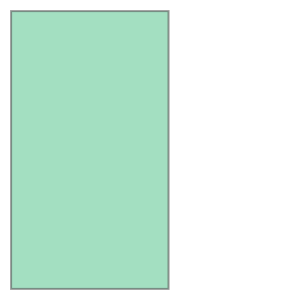

In [ ]:
import geopandas as gpd
from shapely.wkt import loads

# Your WKT string
wkt_string = "POLYGON ((12.314825649509629 56.280928617906284, 12.156498310390248 55.22384079467554, 13.221703723147527 55.22177235339993, 13.361765130349085 56.28468271241903, 12.314825649509629 56.280928617906284))"
# wkt_test = "POLYGON ((12.587007568597471 55.68368093962667, 12.587007568597471 55.673398919770904, 12.611498174224437 55.673398919770904, 12.611498174224437 55.68368093962667, 12.587007568597471 55.68368093962667))"

# Convert WKT string to Shapely geometry
geometry = loads(wkt_string)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=[geometry])
gdf.crs = "EPSG:4326"  # Assuming the original CRS is WGS84

# Convert to EPSG:25832
gdf = gdf.to_crs(epsg=25832)

bounding_box = STBox.from_geometry(gdf['geometry'][0])
bounding_box = bounding_box.set_srid(25832)
bounding_box.to_geometry()

In [ ]:
ship_cleaned['inside'] = ship_cleaned['trip_meos'].apply(lambda tr: tr.at(bounding_box.to_geometry()))

In [ ]:
filtered_sc = ship_cleaned
filtered_sc = filtered_sc.dropna(subset=['inside'])
filtered_sc.drop(columns=['trip_meos'], axis=1, inplace=True)
filtered_sc.rename(columns={'inside': 'trip_meos'}, inplace=True)

<ipython-input-13-3ca10dc29562>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc.drop(columns=['trip_meos'], axis=1, inplace=True)
<ipython-input-13-3ca10dc29562>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc.rename(columns={'inside': 'trip_meos'}, inplace=True)


In [ ]:
filtered_sc

mmsi                                             asewkt  \
11    203797400  SRID=25832;[POINT(685992.148946373 6220532.380...   
29    209075000  SRID=25832;[POINT(733350.3524062181 6165179.79...   
32    209151000  SRID=25832;[POINT(734640.1738769801 6154878.58...   
33    209151000  SRID=25832;[POINT(576264.7136598952 6223211.60...   
34    209151000  SRID=25832;[POINT(729199.3892086856 6176402.41...   
...         ...                                                ...   
8761  636020564  SRID=25832;[POINT(365294.2592956269 6398580.51...   
8797  636022191  SRID=25832;[POINT(601377.8782639694 6394296.82...   
8811  636022866  SRID=25832;[POINT(386795.1421416344 6382808.72...   
8817  636022913  SRID=25832;[POINT(971215.6213491189 6211143.90...   
8822  636023347  SRID=25832;[POINT(769928.2281890134 6131514.25...   

                                                    sog  \
11    [6.3@2023-10-02 10:31:15+02, 6.4@2023-10-02 10...   
29    [8.1@2023-10-01 00:00:08+02, 8.1@2023-10-01 00...   
32    [7.6@2023-10-01 00:00:04+02, 7.6@2023-10-01 00...   
33    [7.6@2023-10-01 00:00:04+02, 7.6@2023-10-01 00...   
34    [7.6@2023-10-01 00:00:04+02, 7.6@2023-10-01 00...   
...                                                 ...   
8761  [12.2@2023-10-02 12:59:16+02, 12.2@2023-10-02 ...   
8797  [14.9@2023-10-01 00:00:02+02, 14.8@2023-10-01 ...   
8811  [13.1@2023-10-01 00:19:19+02, 13.2@2023-10-01 ...   
8817  [11.1@2023-10-03 00:14:36+02, 11.1@2023-10-03 ...   
8822  [8@2023-10-02 02:57:17+02, 8.2@2023-10-02 03:0...   

                                                    cog  \
11    [71@2023-10-02 10:31:15+02, 69@2023-10-02 10:3...   
29    [175.7@2023-10-01 00:00:08+02, 175.4@2023-10-0...   
32    [3.1@2023-10-01 00:00:04+02, 3.6@2023-10-01 00...   
33    [3.1@2023-10-01 00:00:04+02, 3.6@2023-10-01 00...   
34    [3.1@2023-10-01 00:00:04+02, 3.6@2023-10-01 00...   
...                                                 ...   
8761  [111@2023-10-02 12:59:16+02, 110@2023-10-02 13...   
8797  [52.6@2023-10-01 00:00:02+02, 53.3@2023-10-01 ...   
8811  [357.6@2023-10-01 00:19:19+02, 357.6@2023-10-0...   
8817  [236.4@2023-10-03 00:14:36+02, 236.4@2023-10-0...   
8822  [241.4@2023-10-02 02:57:17+02, 242.3@2023-10-0...   

                                                    rot  \
11                                                  NaN   
29    [0@2023-10-01 00:00:08+02, 0@2023-10-01 18:09:...   
32    [2.9@2023-10-01 00:00:04+02, 4.5@2023-10-01 00...   
33    [2.9@2023-10-01 00:00:04+02, 4.5@2023-10-01 00...   
34    [2.9@2023-10-01 00:00:04+02, 4.5@2023-10-01 00...   
...                                                 ...   
8761  [0@2023-10-02 12:59:16+02, 0@2023-10-03 23:59:...   
8797  [0@2023-10-01 00:00:09+02, 0@2023-10-02 06:26:...   
8811  [0@2023-10-01 00:19:19+02, 0@2023-10-03 02:42:...   
8817  [0@2023-10-03 00:14:36+02, 0@2023-10-03 23:59:...   
8822  [0@2023-10-02 02:57:17+02, 0@2023-10-03 23:59:...   

                                                heading  \
11                                                  NaN   
29    [174@2023-10-01 00:00:08+02, 174@2023-10-01 00...   
32    [6@2023-10-01 00:00:04+02, 6@2023-10-01 00:00:...   
33    [6@2023-10-01 00:00:04+02, 6@2023-10-01 00:00:...   
34    [6@2023-10-01 00:00:04+02, 6@2023-10-01 00:00:...   
...                                                 ...   
8761  [107@2023-10-02 12:59:16+02, 107@2023-10-02 13...   
8797  [54@2023-10-01 00:00:02+02, 54@2023-10-01 00:0...   
8811  [358@2023-10-01 00:19:19+02, 358@2023-10-01 00...   
8817  [235@2023-10-03 00:14:36+02, 235@2023-10-03 01...   
8822  [238@2023-10-02 02:57:17+02, 238@2023-10-02 03...   

                                               sog_meos  \
11    [6.3@2023-10-02 08:31:15+00, 6.4@2023-10-02 08...   
29    [8.1@2023-09-30 22:00:08+00, 8.1@2023-09-30 22...   
32    [7.6@2023-09-30 22:00:04+00, 7.6@2023-09-30 22...   
33    [7.6@2023-09-30 22:00:04+00, 7.6@2023-09-30 22...   
34    [7.6@2023-09-30 22:00:04+00, 7.6@

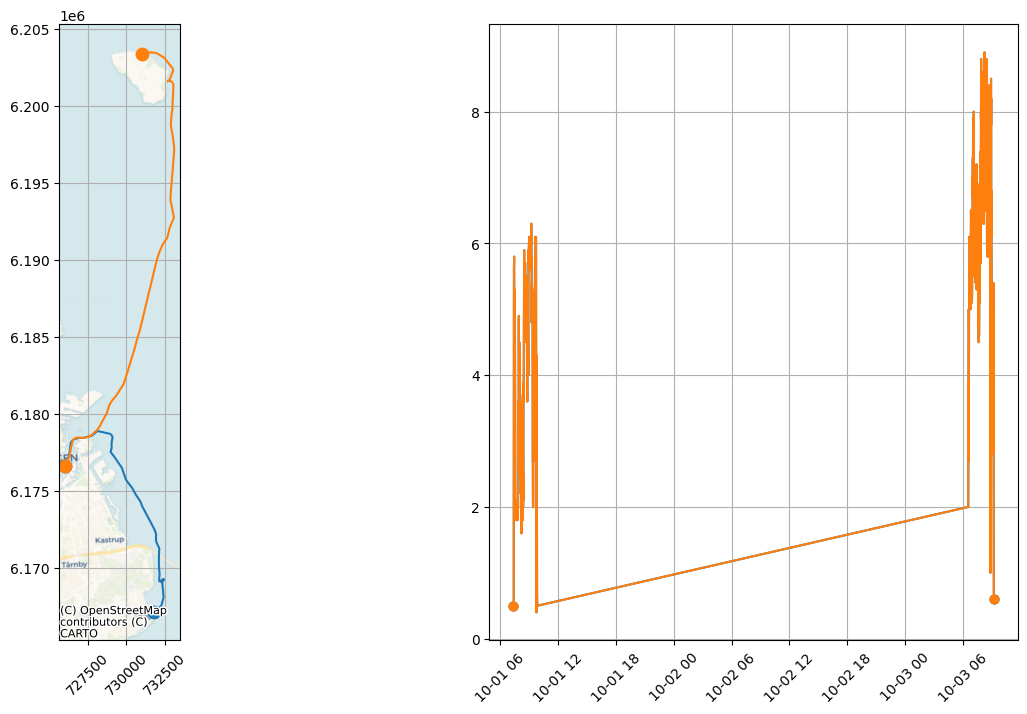

In [ ]:
plot_df = ship_cleaned[ship_cleaned['mmsi'] == 211363840]
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
for _, ship in plot_df.iterrows():
    ship["sog_meos"].plot(axes=axes[1])
    ship["trip_meos"].plot(axes=axes[0])
cx.add_basemap(ax=axes[0], crs="EPSG:25832", source=cx.providers.CartoDB.Voyager)
plt.show()

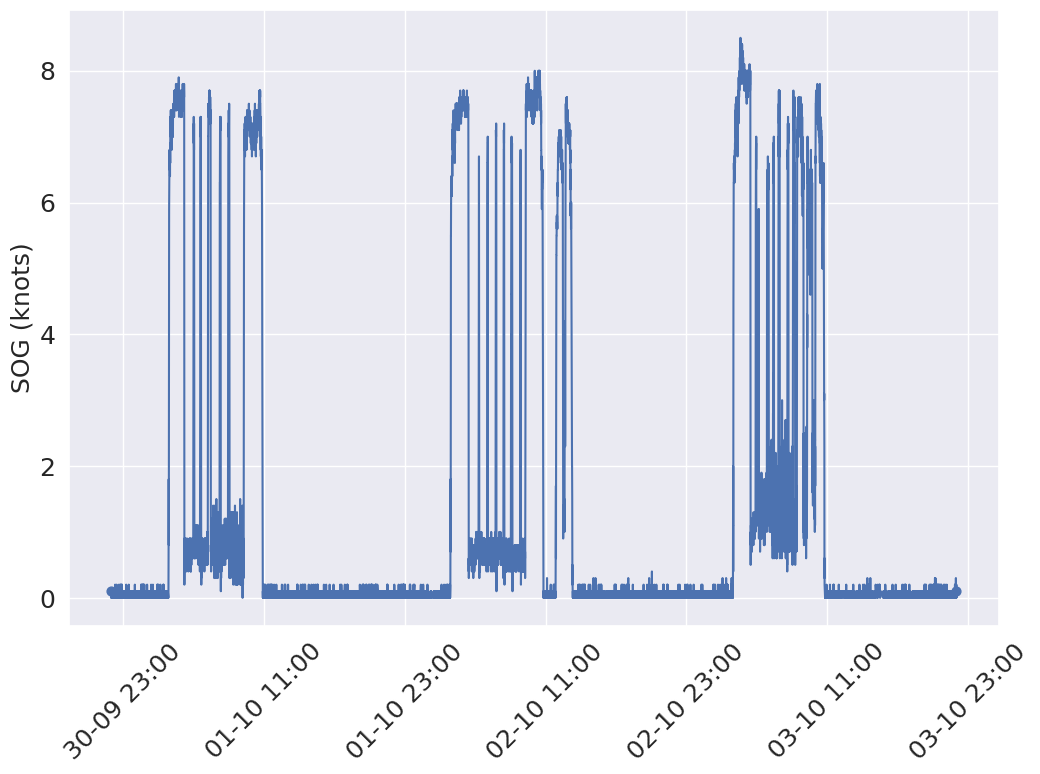

In [ ]:
import matplotlib.dates as mdates

plot_df = ship_cleaned[ship_cleaned['mmsi'] == 211227550]

# Plot for sog_meos
plt.figure(figsize=(12, 8))
for _, ship in plot_df.iterrows():
    ship["sog_meos"].plot()

time_locator = mdates.HourLocator(interval=12)
time_formatter = mdates.DateFormatter('%d-%m %H:00')

# Apply the locator and formatter to the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(time_locator)
ax.xaxis.set_major_formatter(time_formatter)

plt.title('', fontsize=18)
plt.xlabel("", fontsize=18)
plt.ylabel("SOG (knots)", fontsize=18)

# Remove x-tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig('sog_meos.svg', format='svg')
plt.show()

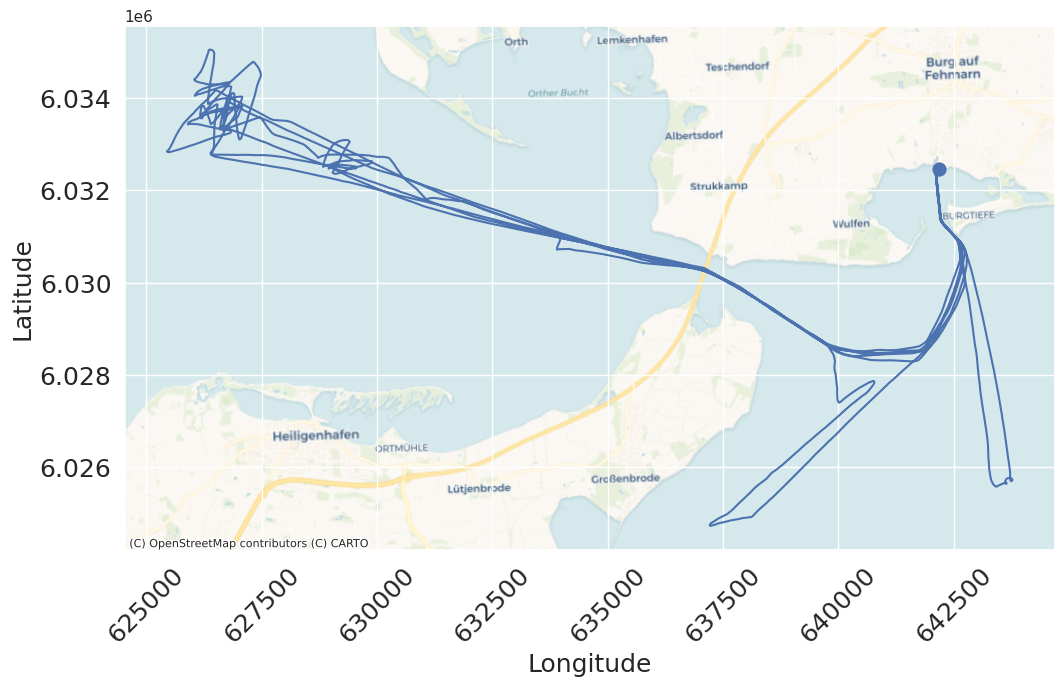

In [ ]:
# Plot for trip_meos
plt.figure(figsize=(12, 8))
ax = plt.gca()
for _, ship in plot_df.iterrows():
    ship["trip_meos"].plot()
plt.title("")
plt.xlabel("Longitude", fontsize=18)
plt.ylabel("Latitude", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cx.add_basemap(ax=ax, crs="EPSG:25832", source=cx.providers.CartoDB.Voyager)
plt.savefig('trip_meos.svg', format='svg')
plt.show()

In [ ]:
filtered_sc["duration"] = filtered_sc.apply(lambda row: row['trip_meos'].duration(), axis=1)
filtered_sc["distance"] = filtered_sc.apply(lambda row: row['trip_meos'].length(), axis=1)

<ipython-input-73-4691871c05fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc["duration"] = filtered_sc.apply(lambda row: row['trip_meos'].duration(), axis=1)
<ipython-input-73-4691871c05fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc["distance"] = filtered_sc.apply(lambda row: row['trip_meos'].length(), axis=1)


In [ ]:
filtered_sc["sog_avg"] = filtered_sc.apply(lambda row: row['sog_meos'].time_weighted_average(), axis=1)
filtered_sc['sog_avg']

<ipython-input-35-d3cf457b0bdd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc["sog_avg"] = filtered_sc.apply(lambda row: row['sog_meos'].time_weighted_average(), axis=1)


11       6.969040
29      10.461694
32       5.008255
33       5.008255
34       5.008255
          ...    
8761    11.842614
8797    12.319086
8811    13.769429
8817     8.832430
8822     8.335865
Name: sog_avg, Length: 1104, dtype: float64

In [ ]:
stats = filtered_sc.groupby('mmsi').aggregate({
        'duration': 'sum',
      'distance': 'sum'}
).reset_index()
stats

mmsi               duration       distance
0    203797400 0 days 00:11:29.607549    2563.622030
1    209075000 0 days 03:39:56.429546   70578.446346
2    209151000 0 days 19:20:15.464988  255198.935210
3    209207000 0 days 09:40:09.573805  187380.176310
4    209332000 0 days 10:30:30.122420  153478.684626
..         ...                    ...            ...
704  636020564 0 days 07:11:13.102654  151253.788448
705  636022191 0 days 06:47:34.632291  162665.192315
706  636022866 0 days 06:44:53.899777  160214.181792
707  636022913 0 days 00:41:48.284158    9615.053983
708  636023347 0 days 11:05:20.410726  160751.033930

[709 rows x 3 columns]

In [ ]:
stats['duration_hours'] = stats['duration'].dt.total_seconds() / 3600

In [ ]:
%matplotlib inline
sns.set(rc = {'figure.figsize': (8,5)})

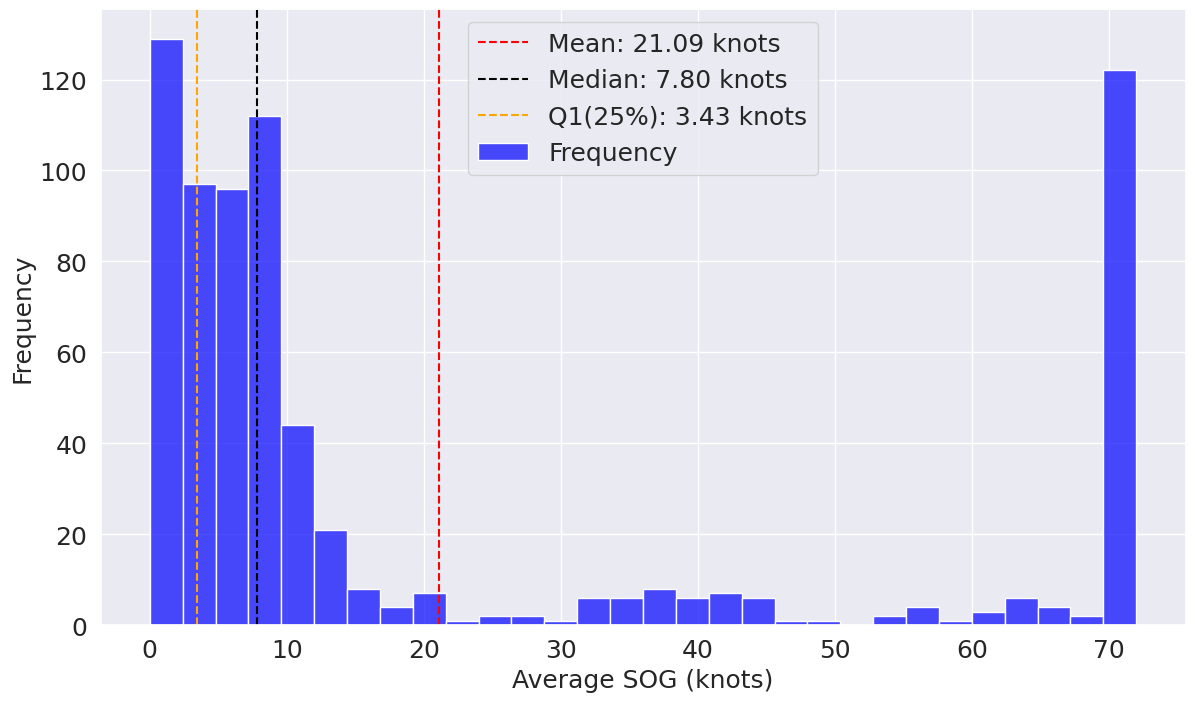

In [ ]:
def plot_distribution_density(df, column, title, xlabel):
    # Calculate mean, median, and Q3
    mean_val = df[column].mean()
    median_val = df[column].median()
    q1_val = df[column].quantile(0.25)

    # Plotting
    plt.figure(figsize=(14, 8))
    sns.histplot(df[column], bins=30, kde=False, color='blue', alpha=0.7, label='Frequency')

    # Add lines for mean, median, and Q3
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_val:.2f} knots')
    plt.axvline(median_val, color='black', linestyle='dashed', linewidth=1.5, label=f'Median: {median_val:.2f} knots')
    plt.axvline(q1_val, color='orange', linestyle='dashed', linewidth=1.5, label=f'Q1(25%): {q1_val:.2f} knots')

    # Add some annotations and legend
    plt.title('')
    plt.xlabel('Average SOG (knots)', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    plt.savefig(f'{column}.svg', format='svg')
    plt.show()


# Plot distributions
plot_distribution_density(stats, 'duration_hours', 'Distribution of Trip Duration with Mean, Median, and Q1', 'Duration (hours)')
# plot_distribution_density(stats, 'distance', 'Distribution of Trip Distance with Mean, Median, and Q1', 'Distance')
# plot_distribution_density(filtered_sc, 'sog_avg', 'Distribution of SOG Average with Mean, Median, and Q1', 'SOG Average')

#### Remove stationary ships from the trajectory

In [ ]:
filtered_sc['stopping_time'] = filtered_sc['sog_meos'].apply(lambda s: s.temporal_less(2).when_true()) # Less than 0.2 knots mean engine stopped
filtered_sc['moving_point'] = filtered_sc.apply(lambda row: row['trip_meos'].minus(row['stopping_time']) if not row['stopping_time'] is None else row['trip_meos'], axis=1)

<ipython-input-14-2e134b5898fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc['stopping_time'] = filtered_sc['sog_meos'].apply(lambda s: s.temporal_less(2).when_true()) # Less than 0.2 knots mean engine stopped
<ipython-input-14-2e134b5898fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc['moving_point'] = filtered_sc.apply(lambda row: row['trip_meos'].minus(row['stopping_time']) if not row['stopping_time'] is None else row['trip_meos'], axis=1)


In [ ]:
filtered_sc = filtered_sc[filtered_sc['moving_point'].notnull()]
filtered_sc['moving_point'] = filtered_sc['moving_point'].apply(lambda x: x.sequences())
filtered_sc = filtered_sc.drop(columns=['trip_meos', 'stopping_time']).rename(columns={'moving_point': 'trip_meos'}).explode('trip_meos')
filtered_sc = filtered_sc.explode('trip_meos')
filtered_sc["duration"] = filtered_sc.apply(lambda row: row['trip_meos'].duration(), axis=1)

<ipython-input-15-49d040faffdb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sc['moving_point'] = filtered_sc['moving_point'].apply(lambda x: x.sequences())


In [ ]:
filtered_sc["duration"] = filtered_sc.apply(lambda row: row['trip_meos'].duration(), axis=1)
filtered_sc["distance"] = filtered_sc.apply(lambda row: row['trip_meos'].length(), axis=1)

#### Get average duration of the ships

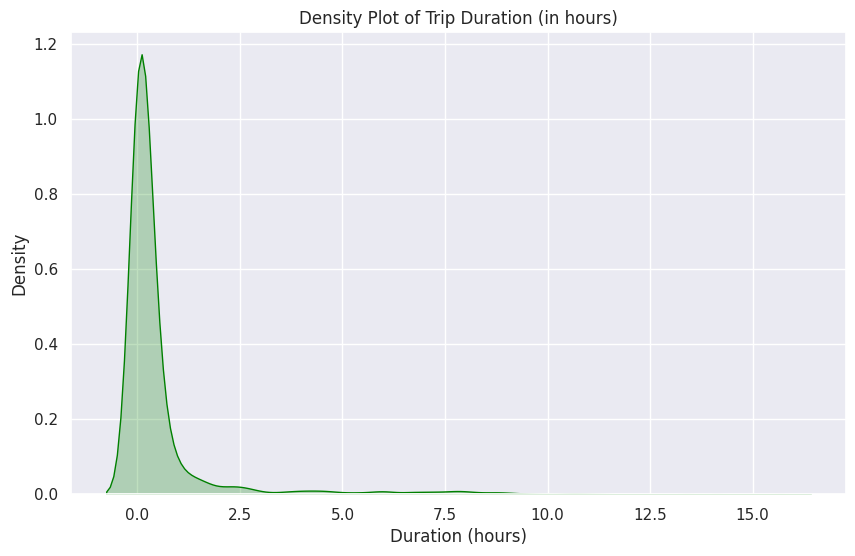

In [ ]:
# Assuming 'duration' is already in timedelta format and ship_cleaned is loaded
# Convert duration from timedelta to hours for easier interpretation
def plot_ship_duration(ship_cleaned):
  ship_cleaned['duration_hours'] = ship_cleaned['duration'].dt.total_seconds() / 3600

  plt.figure(figsize=(10, 6))
  sns.kdeplot(ship_cleaned['duration'].dt.total_seconds()/3600, fill=True, color='green')
  plt.title('Density Plot of Trip Duration (in hours)')
  plt.xlabel('Duration (hours)')
  plt.savefig('')
  plt.show()

filtereplot_ship_duration(filtered_sc)

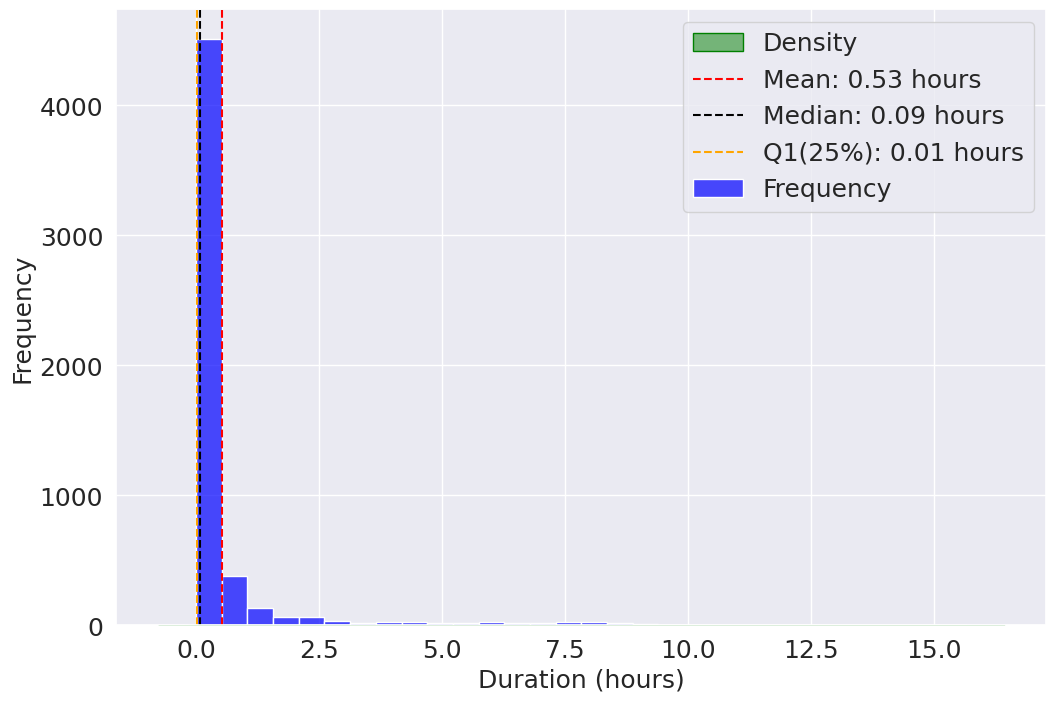

In [ ]:
filtered_sc['duration_hours'] = filtered_sc['duration'].dt.total_seconds() / 3600
def plot_distribution_bar(filtered_sc):
  # Calculate mean, median, mode, and Q3
  mean_duration = filtered_sc['duration_hours'].mean()
  median_duration = filtered_sc['duration_hours'].median()
  q3_duration = filtered_sc['duration_hours'].quantile(0.25)

  # Plotting
  plt.figure(figsize=(12, 8))
  sns.histplot(filtered_sc['duration_hours'], bins=30, kde=False, color='blue', alpha=0.7, label='Frequency')
  sns.kdeplot(filtered_sc['duration_hours'], color='green', fill=True, alpha=0.5, label='Density')

  # Add lines for mean, median, mode, and Q3
  plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_duration:.2f} hours')
  plt.axvline(median_duration, color='black', linestyle='dashed', linewidth=1.5, label=f'Median: {median_duration:.2f} hours')
  plt.axvline(q3_duration, color='orange', linestyle='dashed', linewidth=1.5, label=f'Q1(25%): {q3_duration:.2f} hours')

  # Add some annotations and legend
  plt.title('')
  plt.xlabel('Duration (hours)', fontsize=18)
  plt.ylabel('Frequency', fontsize=18)
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.legend(fontsize=18)

  plt.savefig('duration_split.svg', format='svg')

  plt.show()

plot_distribution_bar(filtered_sc)

#### Delete if duration is less than 15 minutes or if the total points is less than 40

In [ ]:
MIN_SECONDS = 900
MIN_POINTS = 40

# Filter condition for duration in seconds being 600 or less
min_duration = filtered_sc['duration'].dt.total_seconds() > MIN_SECONDS

# Filter condition for the number of instants in 'trip_meos' being less than 40
min_point = filtered_sc['trip_meos'].apply(lambda x: x.num_instants()) >= MIN_POINTS

# Apply both filters to the DataFrame
# ship_cleaned = ship_cleaned[min_point]
filtered_sc = filtered_sc[min_duration & min_point]

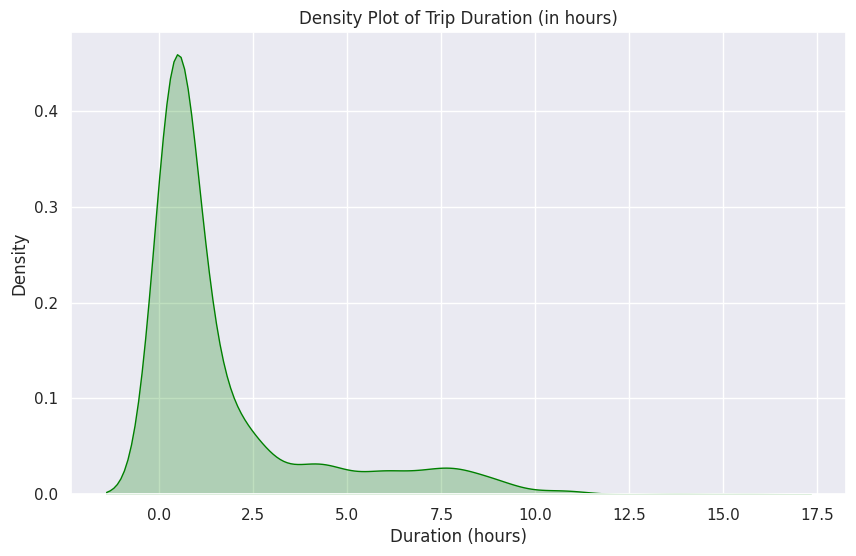

In [ ]:
plot_ship_duration(filtered_sc)

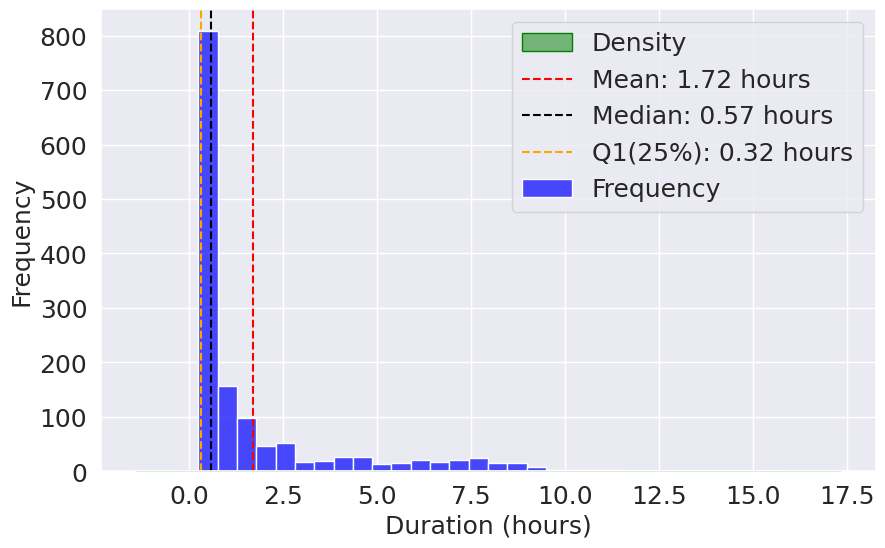

In [ ]:
plot_distribution_bar(filtered_sc)

#### Plotting based on length

In [ ]:
def get_mode(df, group_by, attribute, mode='mean'):
  if mode == 'mean':
    return df.groupby(group_by)[attribute].mean()
  elif mode == 'sum':
    return df.groupby(group_by)[attribute].sum()

  return None

def plot_distribution(df, group_by, attribute, mode='mean'):
  # Calculate average delta_t for each track_id
  track_avg = get_mode(df, group_by, attribute, mode)

  # Visualize distribution of average delta_t by track_id with a histogram and density plot
  plt.figure(figsize=(10, 6))
  sns.histplot(track_avg, kde=True, color='skyblue', stat='density', bins=20)
  # Indicate the overall average of the calculated averages
  overall_avg = track_avg.mean()

  plt.axvline(x=overall_avg, color='red', linestyle='--', label=f'Overall Avg = {overall_avg:.2f}')
  plt.title(f'Histogram and Density Plot of Average by {attribute}')
  plt.xlabel(f'Average {attribute}')
  plt.ylabel('Density')
  plt.legend()
  plt.show()

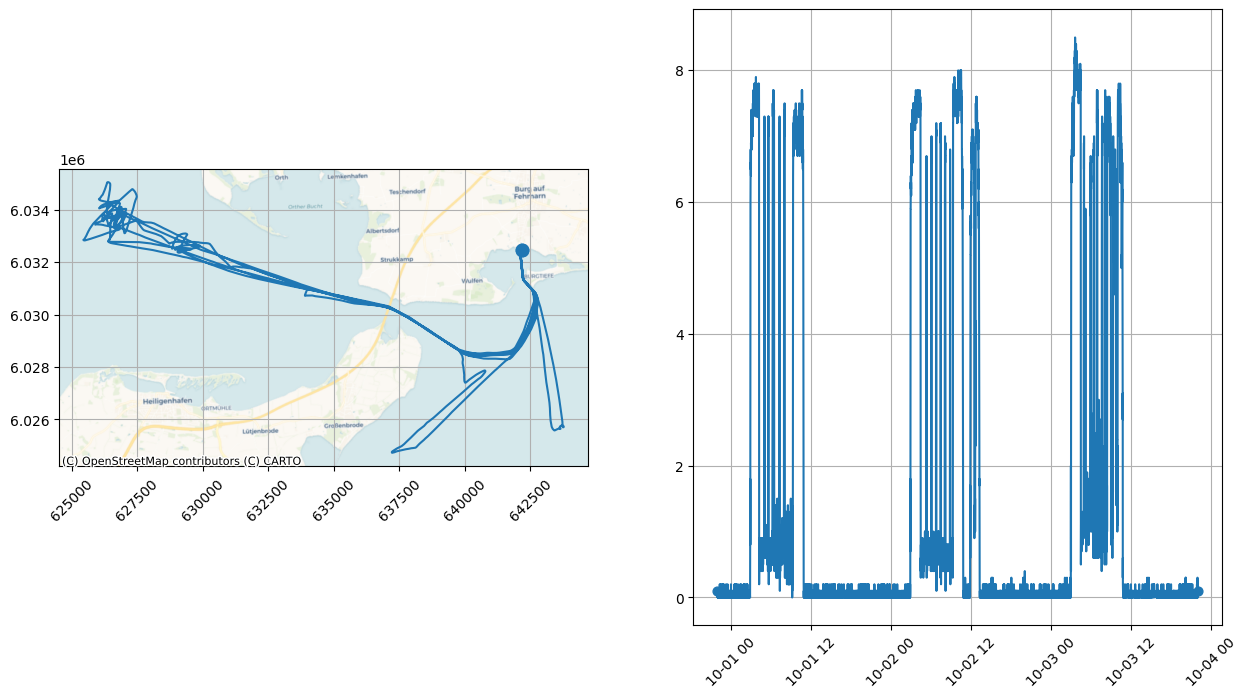

In [ ]:
plot_df = ship_cleaned[ship_cleaned['mmsi'] == 211227550]
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
for _, ship in plot_df.iterrows():
    ship["sog_meos"].plot(axes=axes[1])
    ship["trip_meos"].plot(axes=axes[0])
cx.add_basemap(ax=axes[0], crs="EPSG:25832", source=cx.providers.CartoDB.Voyager)
plt.show()

#### Resampling every 1 mins based on the average delta t

In [ ]:
sampling_rate = '1 minutes'

filtered_sc['trip_sampled'] = filtered_sc.apply(lambda row: row['trip_meos'].temporal_sample(sampling_rate), axis=1)
filtered_sc['sog_sampled'] = filtered_sc.apply(lambda row: row['sog_meos'].temporal_sample(sampling_rate), axis=1)
filtered_sc['cog_sampled'] = filtered_sc.apply(lambda row: row['cog_meos'].temporal_sample(sampling_rate), axis=1)

mmsi                                             asewkt  \
12    205127000  SRID=25832;[POINT(452211.74766221154 6284510.1...   
12    205127000  SRID=25832;[POINT(452211.74766221154 6284510.1...   
12    205127000  SRID=25832;[POINT(452211.74766221154 6284510.1...   
12    205127000  SRID=25832;[POINT(452211.74766221154 6284510.1...   
12    205127000  SRID=25832;[POINT(452211.74766221154 6284510.1...   
...         ...                                                ...   
8829  636092156  SRID=25832;[POINT(621301.9361376775 6147795.94...   
8832  636092635  SRID=25832;[POINT(514566.85031010007 6378018.4...   
8838  636092874  SRID=25832;[POINT(393013.5130499055 6397312.05...   
8839  636092874  SRID=25832;[POINT(660340.9358868384 6384623.41...   
8842  664296000  SRID=25832;[POINT(367092.1537034331 6237598.01...   

                                                    sog  \
12    [0@2023-10-01 00:00:05+02, 0@2023-10-01 00:07:...   
12    [0@2023-10-01 00:00:05+02, 0@2023-10-01 00:07:...   
12    [0@2023-10-01 00:00:05+02, 0@2023-10-01 00:07:...   
12    [0@2023-10-01 00:00:05+02, 0@2023-10-01 00:07:...   
12    [0@2023-10-01 00:00:05+02, 0@2023-10-01 00:07:...   
...                                                 ...   
8829  [12.7@2023-10-01 00:00:09+02, 12.7@2023-10-01 ...   
8832  [12.9@2023-10-01 00:00:06+02, 12.7@2023-10-01 ...   
8838  [11.1@2023-10-02 09:35:49+02, 11.1@2023-10-02 ...   
8839  [11.1@2023-10-02 09:35:49+02, 11.1@2023-10-02 ...   
8842  [13.5@2023-10-01 12:12:35+02, 13.6@2023-10-01 ...   

                                                    cog  \
12    [242@2023-10-01 00:00:05+02, 242@2023-10-01 00...   
12    [242@2023-10-01 00:00:05+02, 242@2023-10-01 00...   
12    [242@2023-10-01 00:00:05+02, 242@2023-10-01 00...   
12    [242@2023-10-01 00:00:05+02, 242@2023-10-01 00...   
12    [242@2023-10-01 00:00:05+02, 242@2023-10-01 00...   
...                                                 ...   
8829  [145.8@2023-10-01 00:00:09+02, 145.8@2023-10-0...   
8832  [239.9@2023-10-01 00:00:06+02, 239.6@2023-10-0...   
8838  [94.9@2023-10-02 09:35:49+02, 96.4@2023-10-02 ...   
8839  [94.9@2023-10-02 09:35:49+02, 96.4@2023-10-02 ...   
8842  [28@2023-10-01 12:12:35+02, 24@2023-10-01 13:3...   

                                                    rot  \
12    [0@2023-10-01 00:00:05+02, 0@2023-10-03 23:59:...   
12    [0@2023-10-01 00:00:05+02, 0@2023-10-03 23:59:...   
12    [0@2023-10-01 00:00:05+02, 0@2023-10-03 23:59:...   
12    [0@2023-10-01 00:00:05+02, 0@2023-10-03 23:59:...   
12    [0@2023-10-01 00:00:05+02, 0@2023-10-03 23:59:...   
...                                                 ...   
8829  [0@2023-10-01 00:00:09+02, 0@2023-10-01 00:00:...   
8832  [-2.2@2023-10-01 00:00:06+02, 2.9@2023-10-01 0...   
8838  [0@2023-10-02 09:35:49+02, 0@2023-10-03 23:59:...   
8839  [0@2023-10-02 09:35:49+02, 0@2023-10-03 23:59:...   
8842  [0@2023-10-01 12:12:35+02, 0@2023-10-03 10:52:...   

                                                heading  \
12    [50@2023-10-01 00:00:05+02, 50@2023-10-01 00:0...   
12    [50@2023-10-01 00:00:05+02, 50@2023-10-01 00:0...   
12    [50@2023-10-01 00:00:05+02, 50@2023-10-01 00:0...   
12    [50@2023-10-01 00:00:05+02, 50@2023-10-01 00:0...   
12    [50@2023-10-01 00:00:05+02, 50@2023-10-01 00:0...   
...                                                 ...   
8829  [144@2023-10-01 00:00:09+02, 144@2023-10-01 00...   
8832  [244@2023-10-01 00:00:06+02, 244@2023-10-01 00...   
8838  [93@2023-10-02 09:35:49+02, 93@2023-10-02 09:3...   
8839  [93@2023-10-02 09:35:49+02, 93@2023-10-02 09:3...   
8842  [28@2023-10-01 12:12:35+02, 25@2023-10-01 13:3...   

                                               sog_meos  \
12    [0@2023-09-30 22:00:05+00, 0@2023-09-30 22:07:...   
12    [0@2023-09-30 22:00:05+00, 0@2023-09-30 22:07:...   
12    [0@2023-09-30 22:00:05+00, 0@2023-09-30 22:07:...   
12    [0@2023-09-30 22:00:05+00, 0@2023-09-30 22:07:...   
12    [0@2023-09-30 22:00:05+00, 0@2023

In [ ]:
filtered_attr = ['trip_meos', 'sog_meos', 'cog_meos', 'distance',  "duration", "duration_hours", "asewkt", 'sog', 'cog', 'rot', 'heading']
filtered_sc = filtered_sc.drop(filtered_attr, axis=1)

#### Assign new mmsi id for different ship track or in case gap is more than 10 minutes

In [ ]:
# Generate a unique ID for each row within the same mmsi group
filtered_sc['id'] = filtered_sc.groupby('mmsi').cumcount() + 1

# Combine 'mmsi' with the new 'id' to create a formatted label
filtered_sc['mmsi_id'] = filtered_sc['mmsi'].astype(str) + '_' + filtered_sc['id'].astype(str)

# Drop the temporary 'id' column if you don't need it
filtered_sc.drop(columns=['id', 'mmsi'], inplace=True)
filtered_sc.head(50)

trip_sampled  \
12  {POINT(452260.40376022493 6284523.85459505)@20...   
12  {POINT(431408.8154892419 6326788.6688200105)@2...   
12  {POINT(432202.6180019331 6345404.586057988)@20...   
12  {POINT(446392.90161875176 6347251.203184258)@2...   
12  {POINT(442104.19444004813 6346841.07958594)@20...   
12  {POINT(436543.4621692488 6345120.820251088)@20...   
12  {POINT(437624.874714958 6346525.618864208)@202...   
12  {POINT(434655.40913152776 6355289.117327914)@2...   
12  {POINT(421529.44990942354 6355660.117176636)@2...   
12  {POINT(428269.21479845635 6358837.39218304)@20...   
12  {POINT(443821.5699114144 6359980.058748705)@20...   
12  {POINT(437921.78761213337 6342786.059232916)@2...   
12  {POINT(435351.0535250459 6341972.6902039545)@2...   
12  {POINT(435293.6234921437 6343829.96539812)@202...   
12  {POINT(429977.0532590009 6341459.728349891)@20...   
12  {POINT(423990.79875433753 6339375.5479848385)@...   
12  {POINT(432107.27509600506 6341634.373252893)@2...   
12  {POINT(434304.6234837837 6340792.821084924)@20...   
12  {POINT(439187.2305503647 6343160.898759624)@20...   
12  {POINT(431775.8834633182 6341320.294936866)@20...   
12  {POINT(427103.2137934421 6342141.237838799)@20...   
13  {POINT(419466.1834624946 6340164.672095495)@20...   
13  {POINT(417420.44118983607 6338096.768579609)@2...   
13  {POINT(417513.2359706324 6339677.531272665)@20...   
13  {POINT(428261.70420590776 6334410.449542346)@2...   
13  {POINT(422516.48468484246 6346820.617194018)@2...   
13  {POINT(426084.98828652885 6347106.312749366)@2...   
13  {POINT(428176.3373702968 6347631.26108112)@202...   
13  {POINT(427977.76109793846 6342777.652435213)@2...   
13  {POINT(428226.3074228708 6342689.857256289)@20...   
13  {POINT(425652.83287137555 6341619.250124158)@2...   
13  {POINT(428201.80929220887 6342119.050150865)@2...   
13  {POINT(421135.03530351474 6339407.076945806)@2...   
13  {POINT(428909.12067739904 6324740.882005756)@2...   
13  {POINT(452319.7837995871 6284538.21796345)@202...   
13  {POINT(391708.6222078586 6299139.334463122)@20...   
13  {POINT(391170.57613254443 6298430.547774534)@2...   
13  {POINT(390974.5862509515 6300378.243962437)@20...   
14  {POINT(442214.95250554173 6339331.505225976)@2...   
14  {POINT(441615.6039285839 6340989.97603455)@202...   
14  {POINT(436744.50608415913 6339423.37498168)@20...   
14  {POINT(429311.2506888501 6341120.825796562)@20...   
14  {POINT(437123.72412151075 6356884.553376948)@2...   
14  {POINT(444487.4924300759 6360774.73849275)@202...   
14  {POINT(435185.3638787392 6360723.58103116)@202...   
14  {POINT(430272.7622355781 6359848.786580112)@20...   
14  {POINT(435998.68276848446 6358897.834319734)@2...   
14  {POINT(448863.97115162964 6358511.8180281175)@...   
14  {POINT(435248.9070150719 6358061.842673354)@20...   
14  {POINT(441639.32376135525 6359796.078774402)@2...   

                                          sog_sampled  \
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:...   
12  {0@2023-09-30 22:01:00+00, 0@2023-09-30 22:02:

In [ ]:
filtered_sc = filtered_sc[filtered_sc['trip_sampled'].notnull()]

#### Explode the MEOS datatype for training

In [ ]:
drop_attributes = ["trip_sampled", "cog_sampled", "sog_sampled"]

def explode_meos_datatype(filtered_sc, column_name, target_name, drop_attr):
  df = filtered_sc.copy()
  df = df.drop(drop_attr, axis=1)

  df[target_name] = filtered_sc[column_name].apply(lambda tr: tr.values())
  df["t"] = filtered_sc[column_name].apply(lambda tr: tr.timestamps())
  df = df.explode([target_name, "t"], ignore_index=True)
  df = df.sort_values(by=['mmsi_id', 't'])

  return df

In [ ]:
traj_df = explode_meos_datatype(filtered_sc, 'trip_sampled', 'trip', drop_attributes)
traj_df.head()

mmsi_id                                          trip  \
0  205127000_1   POINT (452260.40376022493 6284523.85459505)   
1  205127000_1  POINT (452361.86290070537 6284532.629536026)   
2  205127000_1  POINT (452453.37221988477 6284479.392813965)   
3  205127000_1  POINT (452497.72218535835 6284379.739772592)   
4  205127000_1   POINT (452550.8567509079 6284277.614803838)   

                          t  
0 2023-10-01 09:40:00+00:00  
1 2023-10-01 09:41:00+00:00  
2 2023-10-01 09:42:00+00:00  
3 2023-10-01 09:43:00+00:00  
4 2023-10-01 09:44:00+00:00

In [ ]:
sog_df = explode_meos_datatype(filtered_sc, 'sog_sampled', 'sog', drop_attributes)
sog_df.head()

mmsi_id  sog                         t
0  205127000_1  0.0 2023-09-30 22:01:00+00:00
1  205127000_1  0.0 2023-09-30 22:02:00+00:00
2  205127000_1  0.0 2023-09-30 22:03:00+00:00
3  205127000_1  0.0 2023-09-30 22:04:00+00:00
4  205127000_1  0.0 2023-09-30 22:05:00+00:00

In [ ]:
cog_df = explode_meos_datatype(filtered_sc, 'cog_sampled', 'cog', drop_attributes)
cog_df.head()

mmsi_id    cog                         t
0  205127000_1  242.0 2023-09-30 22:01:00+00:00
1  205127000_1  242.0 2023-09-30 22:02:00+00:00
2  205127000_1  242.0 2023-09-30 22:03:00+00:00
3  205127000_1  242.0 2023-09-30 22:04:00+00:00
4  205127000_1  242.0 2023-09-30 22:05:00+00:00

#### Combined SOG, COG and Trip to create one dataset

In [ ]:
def combine_and_interpolate(traj_df, dfs, columns):
    """
    Merges specified columns from other DataFrames into a trajectory DataFrame and interpolates them.

    Parameters:
    - traj_df (DataFrame): The main trajectory DataFrame.
    - dfs (list of DataFrame): List of DataFrames from which to merge columns.
    - columns (list of str): List of column names to merge and interpolate, in the same order as the dfs list.

    Returns:
    - DataFrame: The updated DataFrame with interpolated values.
    """
    combined_df = traj_df.copy()

    for df, col in zip(dfs, columns):
        # Merge each DataFrame on the index; assume each df has a column named as specified in 'col'
        combined_df = combined_df.merge(df[[col]], how='left', left_index=True, right_index=True)

        # Interpolate the merged column
        combined_df[col] = combined_df[col].interpolate(method='linear')

    return combined_df

In [ ]:
columns = ['sog', 'cog']

dfs = [sog_df, cog_df]

combined_df = combine_and_interpolate(
    traj_df=traj_df,
    dfs=dfs,
    columns=columns
)
combined_df.head()

mmsi_id                                          trip  \
0  205127000_1   POINT (452260.40376022493 6284523.85459505)   
1  205127000_1  POINT (452361.86290070537 6284532.629536026)   
2  205127000_1  POINT (452453.37221988477 6284479.392813965)   
3  205127000_1  POINT (452497.72218535835 6284379.739772592)   
4  205127000_1   POINT (452550.8567509079 6284277.614803838)   

                          t  sog    cog  
0 2023-10-01 09:40:00+00:00  0.0  242.0  
1 2023-10-01 09:41:00+00:00  0.0  242.0  
2 2023-10-01 09:42:00+00:00  0.0  242.0  
3 2023-10-01 09:43:00+00:00  0.0  242.0  
4 2023-10-01 09:44:00+00:00  0.0  242.0

#### Save to checkpoint csv (Optional)

In [ ]:
combined_df.to_csv('./combined_data_training_bbox_1min_2knot_trackid_finalbbox.csv', index=False)

In [ ]:
# List of possible date formats
date_formats = [
    "%Y-%m-%d %H:%M:%S.%f%z",
    "%Y-%m-%d %H:%M:%S%z",
    "%Y-%m-%d %H:%M:%S",
    "%Y-%m-%d"
]

# Custom date parser function
def parse_date(date_str):
    for fmt in date_formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format for {date_str} not recognized")


combined_df = pd.read_csv('./combined_data_training_bbox_1min_2knot_trackid.csv', parse_dates=['t'], date_parser=parse_date)

<ipython-input-91-6a188e26149c>:19: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  combined_df = pd.read_csv('./combined_data_training_bbox_1min_2knot_trackid.csv', parse_dates=['t'], date_parser=parse_date)


#### Assign track id  to define the voyage (Optional)

In [ ]:
# # Assuming traj_df is set up correctly with 'mmsi' and 't' already part of it
combined_df['t'] = pd.to_datetime(combined_df['t'])
combined_df.set_index('t', inplace=True)
#  # Ensure 't' is the index for resampling
combined_df

t      mmsi_id  \
0     2023-10-01 15:16:00+00:00  209207000_1   
1     2023-10-01 15:17:00+00:00  209207000_1   
2     2023-10-01 15:18:00+00:00  209207000_1   
3     2023-10-01 15:19:00+00:00  209207000_1   
4     2023-10-01 15:20:00+00:00  209207000_1   
...                         ...          ...   
37878 2023-10-02 18:38:00+00:00  664296000_1   
37879 2023-10-02 18:39:00+00:00  664296000_1   
37880 2023-10-02 18:40:00+00:00  664296000_1   
37881 2023-10-02 18:41:00+00:00  664296000_1   
37882 2023-10-02 18:42:00+00:00  664296000_1   

                                              trip       sog        cog  
0      POINT (635931.4644065286 6050899.294070026)    10.705      44.38  
1       POINT (636244.137708338 6050889.553803406)  9.544019  44.187679  
2      POINT (636527.9546501781 6050779.301503603)  9.170813  47.438876  
3      POINT (636822.8689854274 6050676.749575717)  8.797608  50.690072  
4      POINT (637109.7954672845 6050557.859957917)  8.424402  53.941268  
...                                            ...       ...        ...  
37878  POINT (657145.6665182244 6042858.812783909)       0.0        0.0  
37879  POINT (657550.6258256462 6042698.529965383)       0.0        0.0  
37880  POINT (657954.3211527044 6042555.004683591)       0.0        0.0  
37881  POINT (658361.4909821237 6042402.052597391)       0.0        0.0  
37882  POINT (658756.0792898735 6042230.023477479)       0.0        0.0  

[37883 rows x 5 columns]

In [ ]:
# Prepare a list to collect processed data
processed_data = []

frequency = '2H' # 15 minutes
# Group by 'mmsi' to process each ship's data separately
for mmsi, group in combined_df.groupby('mmsi_id'):
    interval_starts = group.resample(frequency).asfreq().index
    group['interval_start'] = group.index.floor('frequency')
    group['track_id'] = group['interval_start'].astype('category').cat.codes

    # Append the processed group
    processed_data.append(group)

# Concatenate all the processed groups back into a single DataFrame
final_df = pd.concat(processed_data)

# Reset the index to move 't' from index to a column
final_df.reset_index(inplace=True)
final_df.head(30)

In [ ]:
# Make sure both mmsi and track_id are in string format
final_df['mmsi_id'] = final_df['mmsi_id'].astype(str)
final_df['track_id'] = final_df['track_id'].astype(str)

# Concatenate mmsi with track_id to create a new track_id
final_df['track_id'] = final_df['mmsi_id'] + '_' + final_df['track_id']

In [ ]:
final_df = final_df.drop(columns=['interval_start'])

#### Run this in case no need to define voyage

In [ ]:
final_df = combined_df

#### Plot track id to check the interpolation

In [ ]:
def plot_interpolation_by_mmsi(df, mmsi):
  plot_df = df[df['mmsi_id'] == mmsi]
  gdf = gpd.GeoDataFrame(plot_df, geometry='trip')
  fig, ax = plt.subplots(figsize=(10, 10))  # Adjust size as needed
  gdf.plot(ax=ax, column="mmsi_id")  # Customize plot parameters

  plt.show()

def plot_interpolation(df):
  gdf = gpd.GeoDataFrame(df, geometry='trip')
  fig, ax = plt.subplots(figsize=(10, 10))  # Adjust size as needed
  gdf.plot(ax=ax, column="mmsi_id",  markersize=0.1)  # Customize plot parameters
  cx.add_basemap(ax=ax, crs="EPSG:4326", source=cx.providers.CartoDB.Voyager)
  plt.show()

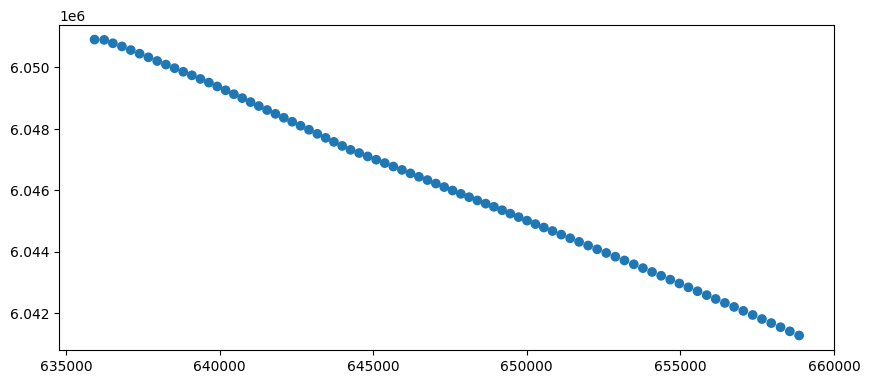

In [ ]:
plot_df = plot_interpolation_by_mmsi(final_df, 	'209207000_1')

##### Investigate the mean of the length after interpolation

In [ ]:
# Calculate the length of each trajectory and store these in a new column
check_df = pd.DataFrame()
check_df['mmsi_id'] = final_df['mmsi_id'].copy()
# check_df['track_id'] = final_df['track_id'].copy()
check_df['trip_meos'] = final_df.apply(lambda row: TGeomPointInst(point=row['trip'], timestamp=row['t']), axis=1)

In [ ]:
attr = ['sog', 'speed']
check_df['speed_meos'] = final_df.apply(lambda row: TFloatInst(value=row[attr[0]], timestamp=row['t']), axis=1)

##### Investigate the speed distribution and the distance distribution of the track

In [ ]:
group_by = 'mmsi_id'

track_trajectories = (
    check_df.groupby(group_by)
    .aggregate(
        {
            "trip_meos": lambda x: TGeomPointSeq.from_instants(x, upper_inc=True),
            "speed_meos": lambda x: TFloatSeq.from_instants(x, upper_inc=True),
        }
    )
    .rename({"trip_meos": "trajectory", "speed_meos": "speed"}, axis=1)
)

In [ ]:
track_trajectories["distance"] = track_trajectories["trajectory"].apply(lambda t: t.length())
track_trajectories["duration"] = track_trajectories["trajectory"].apply(lambda t: t.duration())
track_trajectories["speed_avg"] = track_trajectories["speed"].apply(lambda t: t.time_weighted_average())

In [ ]:
def plot_dist(track_trajectories, attr):
  mean_duration = track_trajectories[attr].mean()
  median_duration = track_trajectories[attr].median()
  q1_duration = track_trajectories[attr].quantile(0.25)

  # Plotting
  plt.figure(figsize=(10, 6))
  sns.histplot(track_trajectories[attr] , bins=30, kde=False, color='blue', alpha=0.7, label='Frequency')

  # # Add lines for mean, median, mode, and Q1
  plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_duration:.2f}')
  plt.axvline(median_duration, color='black', linestyle='dashed', linewidth=1.5, label=f'Median: {median_duration:.2f}')
  plt.axvline(q1_duration, color='orange', linestyle='dashed', linewidth=1.5, label=f'Q1 (25%): {q1_duration:.2f}')

  # Add some annotations and legend
  plt.title('Distribution of Tripwith Mean, Median, Mode, and Q3')
  plt.xlabel(attr)
  plt.ylabel('Frequency')
  plt.legend()

  plt.show()

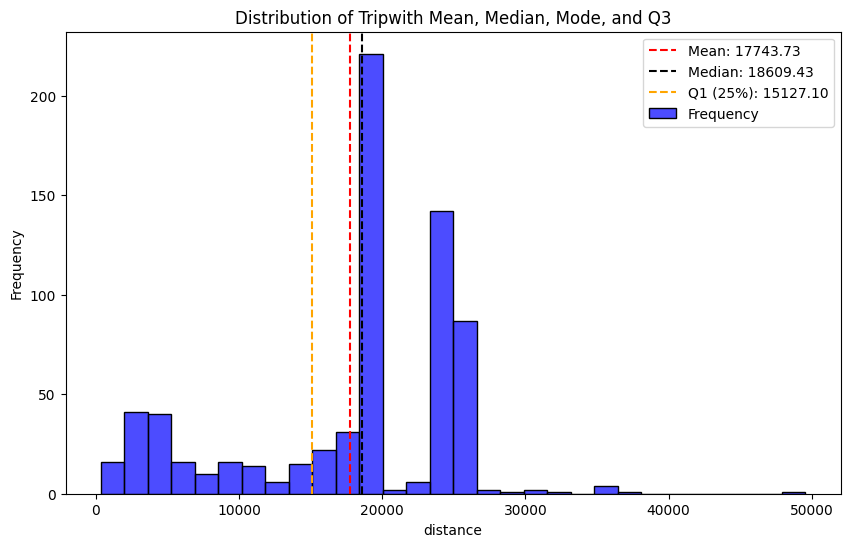

In [ ]:
plot_dist(track_trajectories, 'distance')

##### Investigate and remove the trajecotry with speed average less than the threshold (Optional)

In [ ]:
threshold = 0.2

track_trajectories = track_trajectories[(track_trajectories['speed_avg'] < threshold)]
track_trajectories

trajectory  \
mmsi_id                                                          
212385000_1  [POINT(658897.5229919736 6045766.85728527)@202...   
212423000_1  [POINT(636241.0345005298 6049935.553324381)@20...   
212519000_1  [POINT(659029.0202981761 6045966.248039365)@20...   
212949000_1  [POINT(658765.7105228448 6046950.541070615)@20...   
215090000_1  [POINT(658934.7179229395 6045769.179322159)@20...   
...                                                        ...   
636022811_1  [POINT(636100.1270462727 6051314.409875717)@20...   
636023361_1  [POINT(658843.2578868873 6045645.530019378)@20...   
636091866_1  [POINT(658866.9653370503 6045887.346202207)@20...   
636092156_1  [POINT(636033.6098257084 6051087.513438038)@20...   
664296000_1  [POINT(636195.4633605533 6050948.765711321)@20...   

                                                         speed      distance  \
mmsi_id                                                                        
212385000_1  [0.103451803576841@2023-10-01 22:09:00+00, 0.1...  24738.015795   
212423000_1  [0.120729766595938@2023-10-01 17:30:00+00, 0.1...  24259.226054   
212519000_1  [0.136416338284329@2023-10-03 00:46:00+00, 0.1...  24423.432547   
212949000_1  [0.158241133676872@2023-10-01 18:10:00+00, 0.1...  23969.008927   
215090000_1  [0.171881630797211@2023-10-01 13:33:00+00, 0.1...  25170.368439   
...                                                        ...           ...   
636022811_1  [0.044444444444444@2023-10-03 00:16:00+00, 0.1...  24588.086168   
636023361_1  [0@2023-10-01 21:07:00+00, 0@2023-10-01 21:10:...  24613.404642   
636091866_1  [0.173684210526316@2023-10-02 04:12:00+00, 0.1...  24380.609520   
636092156_1  [0@2023-10-01 03:54:00+00, 0@2023-10-01 03:57:...  25307.191617   
664296000_1  [0.04@2023-10-02 17:47:00+00, 0.04@2023-10-02 ...  24281.853302   

                   duration  speed_avg  
mmsi_id                                 
212385000_1 0 days 01:15:00   0.111977  
212423000_1 0 days 01:08:00   0.128459  
212519000_1 0 days 01:35:00   0.147215  
212949000_1 0 days 00:59:00   0.164948  
215090000_1 0 days 01:26:00   0.181657  
...                     ...        ...  
636022811_1 0 days 01:01:00   0.016904  
636023361_1 0 days 01:08:00   0.033676  
636091866_1 0 days 01:28:00   0.026881  
636092156_1 0 days 01:33:00   0.036836  
664296000_1 0 days 00:55:00   0.012855  

[144 rows x 5 columns]

In [ ]:
# Rename the index and then reset it
track_trajectories.index.name = 'mmsi_id'
track_trajectories = track_trajectories.reset_index()

#### Keep the point with minimum 40 points in the data

In [ ]:
group_attr = 'mmsi_id'

final_df = final_df.groupby(group_attr).filter(lambda x: len(x) >= 40)
final_df = final_df.sort_values(by=[group_attr, 't'])
final_df['delta_t'] = final_df.groupby(group_attr)['t'].diff().dt.total_seconds()
final_df = final_df[~final_df[group_attr].isin(track_trajectories.mmsi_id)]
final_df.head(40)

t      mmsi_id  \
0  2023-10-01 15:16:00+00:00  209207000_1   
1  2023-10-01 15:17:00+00:00  209207000_1   
2  2023-10-01 15:18:00+00:00  209207000_1   
3  2023-10-01 15:19:00+00:00  209207000_1   
4  2023-10-01 15:20:00+00:00  209207000_1   
5  2023-10-01 15:21:00+00:00  209207000_1   
6  2023-10-01 15:22:00+00:00  209207000_1   
7  2023-10-01 15:23:00+00:00  209207000_1   
8  2023-10-01 15:24:00+00:00  209207000_1   
9  2023-10-01 15:25:00+00:00  209207000_1   
10 2023-10-01 15:26:00+00:00  209207000_1   
11 2023-10-01 15:27:00+00:00  209207000_1   
12 2023-10-01 15:28:00+00:00  209207000_1   
13 2023-10-01 15:29:00+00:00  209207000_1   
14 2023-10-01 15:30:00+00:00  209207000_1   
15 2023-10-01 15:31:00+00:00  209207000_1   
16 2023-10-01 15:32:00+00:00  209207000_1   
17 2023-10-01 15:33:00+00:00  209207000_1   
18 2023-10-01 15:34:00+00:00  209207000_1   
19 2023-10-01 15:35:00+00:00  209207000_1   
20 2023-10-01 15:36:00+00:00  209207000_1   
21 2023-10-01 15:37:00+00:00  209207000_1   
22 2023-10-01 15:38:00+00:00  209207000_1   
23 2023-10-01 15:39:00+00:00  209207000_1   
24 2023-10-01 15:40:00+00:00  209207000_1   
25 2023-10-01 15:41:00+00:00  209207000_1   
26 2023-10-01 15:42:00+00:00  209207000_1   
27 2023-10-01 15:43:00+00:00  209207000_1   
28 2023-10-01 15:44:00+00:00  209207000_1   
29 2023-10-01 15:45:00+00:00  209207000_1   
30 2023-10-01 15:46:00+00:00  209207000_1   
31 2023-10-01 15:47:00+00:00  209207000_1   
32 2023-10-01 15:48:00+00:00  209207000_1   
33 2023-10-01 15:49:00+00:00  209207000_1   
34 2023-10-01 15:50:00+00:00  209207000_1   
35 2023-10-01 15:51:00+00:00  209207000_1   
36 2023-10-01 15:52:00+00:00  209207000_1   
37 2023-10-01 15:53:00+00:00  209207000_1   
38 2023-10-01 15:54:00+00:00  209207000_1   
39 2023-10-01 15:55:00+00:00  209207000_1   

                                            trip       sog         cog  \
0    POINT (635931.4644065286 6050899.294070026)    10.705       44.38   
1     POINT (636244.137708338 6050889.553803406)  9.544019   44.187679   
2    POINT (636527.9546501781 6050779.301503603)  9.170813   47.438876   
3    POINT (636822.8689854274 6050676.749575717)  8.797608   50.690072   
4    POINT (637109.7954672845 6050557.859957917)  8.424402   53.941268   
5    POINT (637397.5526903899 6050439.640516019)  8.051196   57.192464   
6     POINT (637684.175054705 6050321.566179099)   7.67799    60.44366   
7    POINT (637969.4726935466 6050202.527604812)  7.304785   63.694856   
8    POINT (638254.0353152553 6050084.982041649)  6.931579   66.946053   
9    POINT (638536.4822571056 6049968.107809065)  6.558373   70.197249   
10    POINT (638818.2151568768 6049850.86423242)  6.185167   73.448445   
11   POINT (639098.5700257492 6049735.538820742)  5.811962   76.699641   
12   POINT (639376.9800282135 6049617.973748653)  5.438756   79.950837   
13    POINT (639652.424404415 6049499.432979343)   5.06555   83.202033   
14    POINT (639923.573735806 6049373.811484635)  4.692344    86.45323   
15    POINT (640195.943036064 6049249.387003666)  4.356667        96.8   
16   POINT (640466.6186645168 6049121.473912566)       3.4       133.9   
17   POINT (640737.9335408709 6048993.383461983)  2.698246  163.759649   
18   POINT (641009.1959546653 6048864.284464181)  1.996491  193.619298   
19  POINT (641278.3999418662 6048735.7007941445)     1.385     222.465   
20   POINT (641547.9862700853 6048605.935570591)  1.265823  241.211392   
21   POINT (641819.3044944389 6048481.328507376)  1.037975  235.287342   
22   POINT (642091.7086226573 6048353.541663652)  0.784571  229.844857   
23   POINT (642363.4766239041 6048223.857500059)  0.681714  202.810571   
24     POINT (642637.56174669 6048093.036690146)  0.578857  175.776286   
25   POINT (642911.0567379806 6047962.992589209)     0.476     148.742   
26   POINT (643182.7117728826 6047830.456479342)  0.373143  121.707714   
27   POINT (643453.7113917598 6047699.941804229)  0.270286   94.673429   
28   POINT (643723.3733489348 60475

In [ ]:
final_df['delta_t'] = final_df['delta_t'].fillna(0)

In [ ]:
final_df.count()

t          26569
mmsi_id    26569
trip       26569
sog        26569
cog        26569
delta_t    26569
dtype: int64

#### Translate cog into a vector

Text(0, 0.5, 'SOG [m/s]')

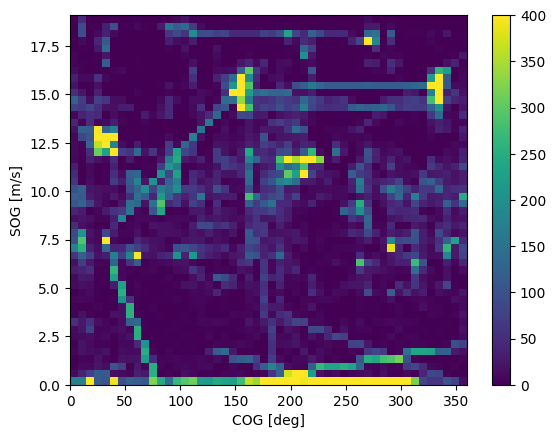

In [ ]:
attr = 'sog'

plt.hist2d(final_df['cog'], (final_df[attr]), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('COG [deg]')
plt.ylabel('SOG [m/s]')

In [ ]:
final_df['cog_rad'] = np.radians(final_df['cog'].astype(float))  # Convert degrees to radians

if attr == 'sog':
  final_df['cog_x'] = (final_df['sog'] * 0.514444) * np.cos(final_df['cog_rad'])
  final_df['cog_y'] = (final_df['sog'] * 0.514444) * np.sin(final_df['cog_rad'])
else:
  final_df['cog_x'] = (final_df['speed']) * np.cos(final_df['cog_rad'])
  final_df['cog_y'] = (final_df['speed']) * np.sin(final_df['cog_rad'])

Text(0, 0.5, 'SOG [m/s]')

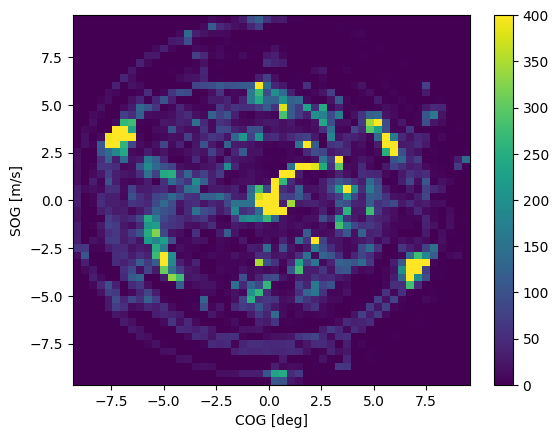

In [ ]:
plt.hist2d(final_df['cog_x'], (final_df['cog_y']), bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('COG [deg]')
plt.ylabel('SOG [m/s]')

#### Investigate the new gaps after resampling

In [ ]:

# from shapely import wkt

# final_df['trip'] = final_df['trip'].apply(wkt.loads)

# Earth's radius in kilometers
R = 6371.0

# Create a GeoDataFrame
trip_gdf = gpd.GeoDataFrame(final_df, geometry="trip")

# Set the CRS to EPSG:25832 (UTM Zone 32N)
trip_gdf.set_crs(epsg=25832, inplace=True)

# Convert to EPSG:4326
trip_gdf = trip_gdf.to_crs(epsg=4326)

# Extract latitude and longitude
trip_gdf["lat"] = trip_gdf["trip"].apply(lambda point: point.x)  # Latitude
trip_gdf["lon"] = trip_gdf["trip"].apply(lambda point: point.y)  # Longitude

# Get previous coordinates within each 'track_id'
trip_gdf["prev_lat"] = trip_gdf.groupby("mmsi_id")["lat"].shift(1)
trip_gdf["prev_lon"] = trip_gdf.groupby("mmsi_id")["lon"].shift(1)

# Convert degrees to radians for Haversine calculations
trip_gdf[["lat_rad", "lon_rad"]] = np.radians(trip_gdf[["lat", "lon"]])
trip_gdf[["prev_lat_rad", "prev_lon_rad"]] = np.radians(trip_gdf[["prev_lat", "prev_lon"]])

# Transform lat/lon and prev_lat/prev_lon into 2D arrays
lat_lon = trip_gdf[["lat", "lon"]].to_numpy()  # 2D array of lat/lon
prev_lat_lon = trip_gdf[["prev_lat", "prev_lon"]].to_numpy()  # 2D array of prev_lat/prev_lon

# Convert degrees to radians
lat_lon_rad = np.radians(lat_lon)
prev_lat_lon_rad = np.radians(prev_lat_lon)

# Calculate Haversine distances for 'gaps'
trip_gdf["gaps"] = [
    haversine_distances([prev, current])[0, 1] * R if not np.isnan(prev[0]) else np.nan
    for prev, current in zip(prev_lat_lon_rad, lat_lon_rad)
]

# Fill NaN values in 'gaps' with 0
trip_gdf["gaps"].fillna(0, inplace=True)

trip_gdf.head()
# trip_gdf = final_df

mmsi_id                       trip                         t   sog  \
0  209075000_1  POINT (12.70237 55.57463) 2023-09-30 22:01:00+00:00   8.1   
1  209075000_1  POINT (12.70269 55.57235) 2023-09-30 22:02:00+00:00  8.18   
2  209075000_1  POINT (12.70294 55.57009) 2023-09-30 22:03:00+00:00   8.1   
3  209075000_1  POINT (12.70318 55.56782) 2023-09-30 22:04:00+00:00   8.1   
4  209075000_1  POINT (12.70338 55.56556) 2023-09-30 22:05:00+00:00   8.0   

          cog  delta_t   cog_rad     cog_x     cog_y        lat        lon  \
0      175.64      0.0  3.065496 -4.154937  0.316787  12.702365  55.574632   
1       176.0     60.0  3.071779 -4.197901  0.293546  12.702692  55.572353   
2      176.78     60.0  3.085393 -4.160418   0.23406  12.702935  55.570090   
3  176.744444     60.0  3.084772 -4.160272  0.236642  12.703179  55.567815   
4  177.411111     60.0  3.096408 -4.111351  0.185896  12.703378  55.565562   

    prev_lat   prev_lon   lat_rad   lon_rad  prev_lat_rad  prev_lon_rad  \
0        NaN        NaN  0.221698  0.969960           NaN           NaN   
1  12.702365  55.574632  0.221704  0.969921      0.221698      0.969960   
2  12.702692  55.572353  0.221708  0.969881      0.221704      0.969921   
3  12.702935  55.570090  0.221712  0.969841      0.221708      0.969881   
4  12.703179  55.567815  0.221716  0.969802      0.221712      0.969841   

       gaps  
0  0.000000  
1  0.249846  
2  0.246979  
3  0.248256  
4  0.245394

#### Plot the distribution of the gaps after interpolation

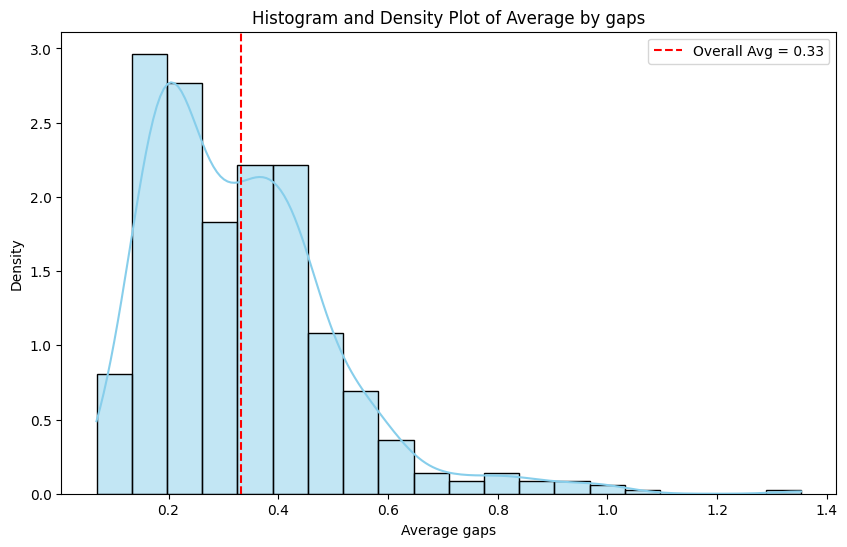

In [ ]:
plot_distribution(trip_gdf, 'mmsi_id', 'gaps')

#### We have seen there's a lot of track with sum of gaps 0, now we remove if the sum of gaps is less than 1km

In [ ]:
# Group by track_id and calculate the sum of gaps
gaps_sum_by_track_id = trip_gdf.groupby('mmsi_id')['gaps'].sum().reset_index(name='sum_gaps')

# Group by track_id and calculate the average SOG
sog_avg_by_track_id = trip_gdf.groupby('mmsi_id')['sog'].mean().reset_index(name='avg_speed')

# Merge the sum_gaps and avg_sog data into one DataFrame
gaps_and_sog = pd.merge(gaps_sum_by_track_id, sog_avg_by_track_id, on='mmsi_id')

# Sort the data by the sum of gaps in ascending order
sorted_by_gaps = gaps_and_sog[gaps_and_sog['sum_gaps'] > 1].sort_values(by='sum_gaps')
track_ids = sorted_by_gaps.mmsi_id

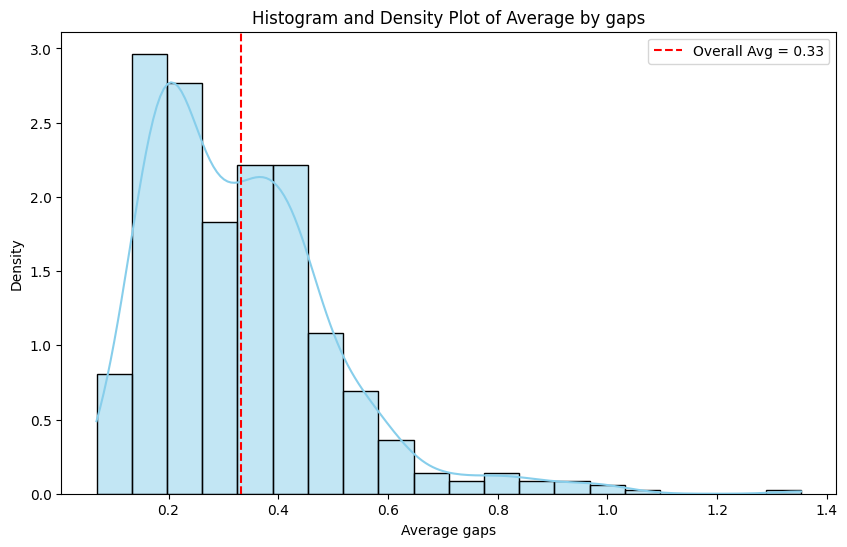

In [ ]:
trip_gdf = trip_gdf[trip_gdf['mmsi_id'].isin(track_ids)]
plot_distribution(trip_gdf, 'mmsi_id', 'gaps')

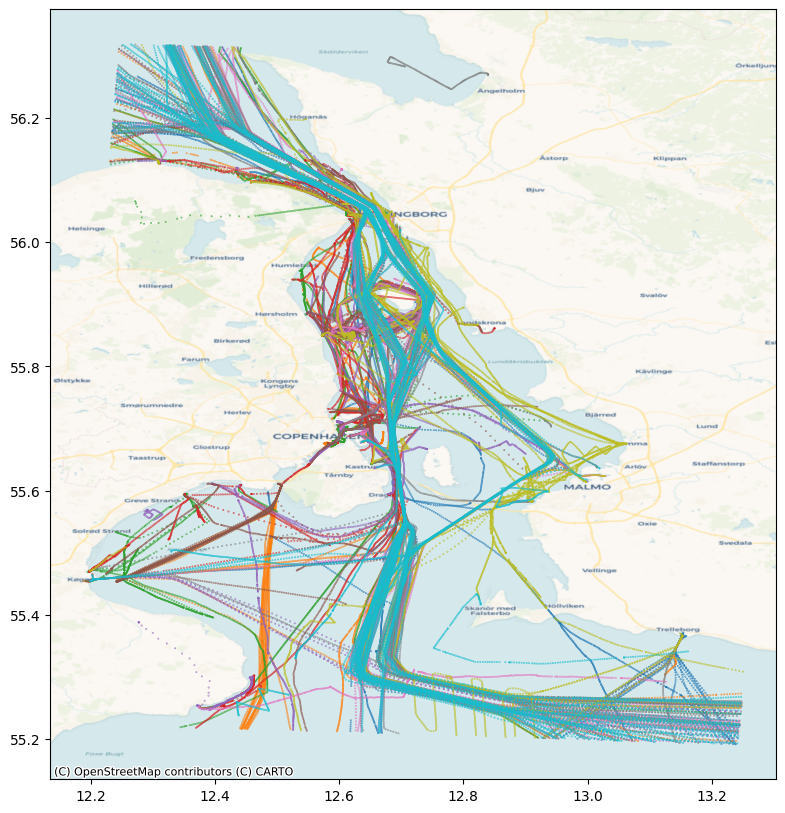

In [ ]:
plot_interpolation(trip_gdf)

In [ ]:
trip_gdf.to_csv('./dataset_3days_sampled_1min_2knots.csv', index=False)